**This Notebook goes along with convnet_devp3.py. Compared to experiment2 notebook, it adds in L2 regularization on fully connected layers. It also adds a Batch Normlization layer after each CONV/FC layer**

In [1]:
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from convnet_devp3 import *

/Users/Zhongyu/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Zhongyu/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Load Data

In [2]:
train_dataset, train_labels, test_dataset, test_labels = load_data()

Loading the training data...
Loading the testing data...


### Split Training and Validation Data

In [3]:
train_dataset, valid_dataset, train_labels, valid_labels = \
    train_test_split(train_dataset, train_labels, test_size=10000,\
    random_state=897, stratify=train_labels)

### Reshape Data - 32x32x3

In [4]:
train_dataset = np.rollaxis(train_dataset.reshape((-1,3,32,32)), 1, 4)
valid_dataset = np.rollaxis(valid_dataset.reshape((-1,3,32,32)), 1, 4)
test_dataset = np.rollaxis(test_dataset.reshape((-1,3,32,32)), 1, 4)
print 'Dataset\t\tFeatureShape\t\tLabelShape'
print 'Training set:\t', train_dataset.shape,'\t', train_labels.shape
print 'Validation set:\t', valid_dataset.shape, '\t', valid_labels.shape
print 'Testing set:\t', test_dataset.shape, '\t', test_labels.shape

Dataset		FeatureShape		LabelShape
Training set:	(40000, 32, 32, 3) 	(40000,)
Validation set:	(10000, 32, 32, 3) 	(10000,)
Testing set:	(10000, 32, 32, 3) 	(10000,)


### Data Augmentation - 50% of training upside down flip; 50% mirror flip

In [5]:
# Dataset Parameters
image_size = 32
num_labels = 10
num_channels = 3
train_dataset, train_labels = preprocess_data(train_dataset, train_labels, num_labels)
valid_dataset, valid_labels = preprocess_data(valid_dataset, valid_labels, num_labels)
test_dataset,  test_labels  = preprocess_data(test_dataset,  test_labels,  num_labels)

### Generate a fixed small batch of data for corase tuning

In [6]:
train_batch_size = 32
valid_batch_size = 32
train_batch, train_label_batch = generate_batch(train_dataset, train_labels, train_batch_size)
valid_batch, valid_label_batch = generate_batch(valid_dataset, valid_labels, valid_batch_size)

### Setup Network Parameters

In [7]:
# Parameters for building blocks
kernel_size3 = 3
kernel_size5 = 5
num_filter = 64
fc_size1 = 512

In [8]:
# Setup shapes for each layer in the convnet
convnet_shapes = [['conv1', [kernel_size5, kernel_size5, num_channels, num_filter]],
                  ['conv2', [kernel_size3, kernel_size3, num_filter, num_filter]],
                  ['conv3', [kernel_size5, kernel_size5, num_filter, num_filter]],
                  ['fc1'  , [(image_size/2/2/2)**2*num_filter, fc_size1]],
                  ['fc2'  , [fc_size1, num_labels]]]

In [20]:
model = convnet_stack
epoch = 101

In [24]:
hyperparams={'keep_prob': .4, 'init_lr': 0.005, 'decay_rate': .7, 'beta':0.01,
             'initializer':tf.truncated_normal_initializer(stddev=.1),'batch_norm':True,
             'decay_steps':500, 'optimizer':tf.train.AdamOptimizer}

In [25]:
graph = tf.Graph()
with graph.as_default():
    tf_data = {'train_X': tf.constant(train_batch), 'train_y': tf.constant(train_label_batch),
               'valid_X': tf.constant(valid_batch), 'valid_y': tf.constant(valid_label_batch),
               'test_X' : None, 'test_y': None}

In [26]:
graph, training_data = train_convnet(graph, model, tf_data, convnet_shapes, hyperparams, epoch, False)

Prepare network parameters ................................
Start training ................................
Initialized
Epoch: 0:	 Loss: 2.306276	 Time cost: 1	Train Acc: 25.00%	Valid Acc: 28%	Learning rate: 0.005000
Epoch: 10:	 Loss: 0.813530	 Time cost: 1	Train Acc: 96.88%	Valid Acc: 22%	Learning rate: 0.005000
Epoch: 20:	 Loss: 0.545226	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 22%	Learning rate: 0.005000
Epoch: 30:	 Loss: 0.473300	 Time cost: 0	Train Acc: 100.00%	Valid Acc: 22%	Learning rate: 0.005000
Epoch: 40:	 Loss: 0.414912	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 22%	Learning rate: 0.005000
Epoch: 50:	 Loss: 0.355933	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 22%	Learning rate: 0.005000
Epoch: 60:	 Loss: 0.310613	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 22%	Learning rate: 0.005000
Epoch: 70:	 Loss: 0.285040	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 22%	Learning rate: 0.005000
Epoch: 80:	 Loss: 0.256894	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 22%	Learning rate: 0

### Implement functions for random search - Log Space Search

In [27]:
def plot_data(data):
    epoch = range(data['train_losses'].shape[0])
    plt.subplot(211)
    plt.plot(epoch, data['train_losses'], label= 'training loss')
    plt.plot(epoch, data['valid_losses'], label='validation loss')
    plt.ylim([-.1,4])
    plt.legend(loc='upper right')
    plt.subplot(212)
    plt.plot(epoch, data['train_acc'], label='training accuracy')
    plt.plot(epoch, data['valid_acc'], label='validation accuracy')
    plt.ylim([0.0, 1.1])
    plt.legend(loc='upper right')
    plt.show()

In [28]:
def random_search(num_experiments, train_batch_size, valid_batch_size, convnet_shapes, epoch):
    experiment_data = {}
    for i in range(num_experiments):
        # Prepare small batch of data for experimental training
        train_batch, train_label_batch = generate_batch(train_dataset, train_labels, train_batch_size)
        valid_batch, valid_label_batch = generate_batch(valid_dataset, valid_labels, valid_batch_size)
        # Sample random HyperParameters
        hyperparams = generate_hyperparams()
        # Prepare data for tensorflow
        graph = tf.Graph()
        with graph.as_default():
            tf_data = {'train_X': tf.constant(train_batch), 'train_y': tf.constant(train_label_batch),
                       'valid_X': tf.constant(valid_batch), 'valid_y': tf.constant(valid_label_batch),
                       'test_X' : None, 'test_y': None}
        hyperparams['initializer'] = tf.truncated_normal_initializer(stddev=hyperparams['init_std'])
        # Train convnet
        model = convnet_stack
        _, training_data = train_convnet(graph, model, tf_data, convnet_shapes, hyperparams, epoch, False)
        key = (hyperparams['keep_prob'], hyperparams['init_lr'], hyperparams['init_std'], hyperparams['beta'])
        experiment_data[key] = training_data
        print "Finished experiment ", str(i)
        print "="*100
    return experiment_data

In [78]:
def generate_hyperparams():
    # Generate random hyperparameters Log Space
    keep_prob = np.random.uniform(0.3, 0.6)
    init_lr = np.random.uniform(0.0001, 0.0009) #10**np.random.uniform(-4,-2)
    init_std = np.random.uniform(0.01, 0.03) #10**np.random.uniform(-3,-1)
    beta = 10**np.random.uniform(-4, -1) # original setting (-6, -1)
    hyperparams={'keep_prob': keep_prob, 'init_lr': init_lr, 'decay_rate': 1., 'decay_steps':1000,
                 'init_std': init_std, 'beta':beta, 'optimizer':tf.train.AdamOptimizer, 'batch_norm':True}
    return hyperparams

### Random Search Through Hyperparameter Space

In [55]:
num_exp = 1
train_batch_size = 64
valid_batch_size = 16
epoch = 101

***
**Good Experiment Record 1**

In [57]:
experiment_data = random_search(num_exp, train_batch_size, valid_batch_size, convnet_shapes, epoch)

Prepare network parameters ................................
Start training ................................
Initialized
Epoch: 0:	 Loss: 2.484950	 Time cost: 1	Train Acc: 7.81%	Valid Acc:  0%	Learning rate: 0.000189
Epoch: 10:	 Loss: 0.743193	 Time cost: 1	Train Acc: 98.44%	Valid Acc: 12%	Learning rate: 0.000189
Epoch: 20:	 Loss: 0.560171	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 12%	Learning rate: 0.000189
Epoch: 30:	 Loss: 0.492696	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 25%	Learning rate: 0.000189
Epoch: 40:	 Loss: 0.476683	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 38%	Learning rate: 0.000189
Epoch: 50:	 Loss: 0.457831	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 31%	Learning rate: 0.000189
Epoch: 60:	 Loss: 0.457271	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 31%	Learning rate: 0.000189
Epoch: 70:	 Loss: 0.441907	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 31%	Learning rate: 0.000189
Epoch: 80:	 Loss: 0.438156	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 31%	Learning rate: 0.

In [58]:
key = experiment_data.keys()[0]
exp_data = experiment_data[key]
print 'keep_prob\t\t', 'learning rate\t\t', 'init_std\t\t', 'beta\t\t\t', 'valid accuracy'
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t', exp_data['valid_acc'][-1]

keep_prob		learning rate		init_std		beta			valid accuracy
0.459676530107 		0.000188639900563 	0.0103675105486 	0.0953807118423 	0.3125


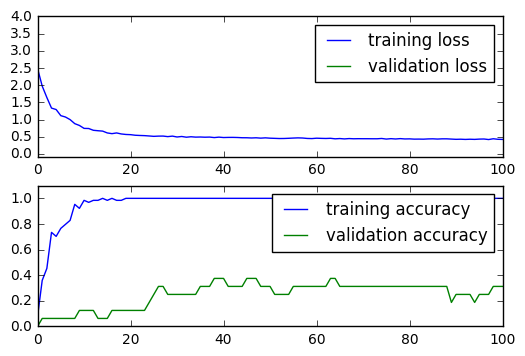

In [59]:
plot_data(exp_data)

***
**Good Experiment Record 2**

In [64]:
experiment_data = random_search(num_exp, train_batch_size, valid_batch_size, convnet_shapes, epoch)

Prepare network parameters ................................
Start training ................................
Initialized
Epoch: 0:	 Loss: 2.550025	 Time cost: 1	Train Acc: 7.81%	Valid Acc:  0%	Learning rate: 0.000286
Epoch: 10:	 Loss: 0.860933	 Time cost: 1	Train Acc: 92.19%	Valid Acc: 12%	Learning rate: 0.000286
Epoch: 20:	 Loss: 0.593718	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 12%	Learning rate: 0.000286
Epoch: 30:	 Loss: 0.521111	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 12%	Learning rate: 0.000286
Epoch: 40:	 Loss: 0.506811	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 12%	Learning rate: 0.000286
Epoch: 50:	 Loss: 0.478365	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 12%	Learning rate: 0.000286
Epoch: 60:	 Loss: 0.464871	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 12%	Learning rate: 0.000286
Epoch: 70:	 Loss: 0.451513	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 12%	Learning rate: 0.000286
Epoch: 80:	 Loss: 0.439206	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 12%	Learning rate: 0.

In [65]:
key = experiment_data.keys()[0]
exp_data = experiment_data[key]
print 'keep_prob\t\t', 'learning rate\t\t', 'init_std\t\t', 'beta\t\t\t', 'valid accuracy'
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t', exp_data['valid_acc'][-1]

keep_prob		learning rate		init_std		beta			valid accuracy
0.510698853396 		0.000285567954519 	0.0284887442333 	0.000804516782004 	0.125


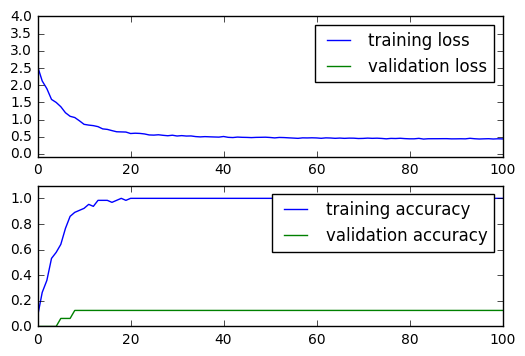

In [67]:
plot_data(exp_data)

***
**Good Experiment Record 3**

In [84]:
experiment_data = random_search(num_exp, train_batch_size, valid_batch_size, convnet_shapes, epoch)

Prepare network parameters ................................
Start training ................................
Initialized
Epoch: 0:	 Loss: 2.399601	 Time cost: 1	Train Acc: 6.25%	Valid Acc: 12%	Learning rate: 0.000265
Epoch: 10:	 Loss: 0.983426	 Time cost: 1	Train Acc: 89.06%	Valid Acc: 25%	Learning rate: 0.000265
Epoch: 20:	 Loss: 0.712979	 Time cost: 1	Train Acc: 98.44%	Valid Acc: 12%	Learning rate: 0.000265
Epoch: 30:	 Loss: 0.608376	 Time cost: 1	Train Acc: 98.44%	Valid Acc: 12%	Learning rate: 0.000265
Epoch: 40:	 Loss: 0.609597	 Time cost: 1	Train Acc: 98.44%	Valid Acc: 12%	Learning rate: 0.000265
Epoch: 50:	 Loss: 0.527505	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 12%	Learning rate: 0.000265
Epoch: 60:	 Loss: 0.526457	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 12%	Learning rate: 0.000265
Epoch: 70:	 Loss: 0.519060	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 12%	Learning rate: 0.000265
Epoch: 80:	 Loss: 0.512885	 Time cost: 1	Train Acc: 100.00%	Valid Acc: 19%	Learning rate: 0.000

In [87]:
key = experiment_data.keys()[0]
exp_data = experiment_data[key]
print 'keep_prob\t\t', 'learning rate\t\t', 'init_std\t\t', 'beta\t\t\t', 'valid accuracy'
print key[0],'\t\t',key[1],'\t',key[2],'\t',key[3],'\t', exp_data['valid_acc'][-1]

keep_prob		learning rate		init_std		beta			valid accuracy
0.30657353283 		0.000265359651372 	0.0236139666842 	0.000218990830845 	0.1875


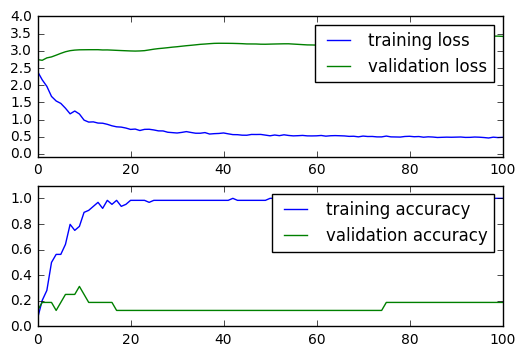

In [86]:
plot_data(exp_data)

***
### Summary
- Trail run parameters:
    - AdamOptimizer
    - Drop out keep prob: 0.4
    - Weights initialization: truncated_normal with stddev=0.015
    - Biases initialization : constant (1.0)
    - CONVNET architecture:
        * conv1: filter size 5x5, num of filters: 64, stride=1, padding=SAME + ReLu
        * pool1: filter size 2x2, max pooling, stride=2, padding=SAME
        * conv2: filter size 3x3, num of filters: 64, stride=1, padding=SAME + ReLu
        * pool2: filter size 2x2, max pooling, stride=2, padding=SAME
        * conv3: filter size 5x5, num of filters: 64, stride=1, padding=SAME + ReLu
        * pool3: filter size 2x2, max pooling, stride=1, padding=SAME
        * fc1  : 512 neurons
        * fc2  : 10 neurons
    - Time cost per epoch:  secs
    - MiniBatch size: 512
    - Total epoches ran: 1200
    - learning rate: 0.0003, decay rate: 0.8, decay steps: 100, staircase: True
    - L2 regularization factor beta: 0.0001~0.0005